In [3]:
# 01_temp_tmin_tmax.R
# This script reads half-hourly temperature data, aggregates it to daily values (mean, min, max),
# and writes the result to a CSV file.

# ---- Package Installation and Loading ----
# Ensure required packages are installed and loaded
required_packages <- c("dplyr", "lubridate")
installed_packages <- rownames(installed.packages())
for (pkg in required_packages) {
    if (!pkg %in% installed_packages) {
        install.packages(pkg, dependencies = TRUE)
    }
    library(pkg, character.only = TRUE)
}

# ---- Data Reading ----
# Read the half-hourly measurement file (CSV)
temp_data <- read.csv("../data/FLX_CH-Oe2_FLUXNET2015_FULLSET_2004-2023_1-3/FLX_CH-Oe2_FLUXNET2015_FULLSET_HH_2004-2023_1-3.csv")
head(temp_data)  # Preview the first few rows

# ---- Timestamp Conversion ----
# Convert TIMESTAMP_START to character (in case of scientific notation)
temp_data$TIMESTAMP_START <- as.character(temp_data$TIMESTAMP_START)
# Extract date (YYYYMMDD) and convert to Date object
temp_data$date <- as.Date(substr(temp_data$TIMESTAMP_START, 1, 8), format = "%Y%m%d")

# Extract hour from timestamp for daylight filtering
temp_data$hour <- as.numeric(substr(temp_data$TIMESTAMP_START, 9, 10))

# ---- Data Aggregation ----
# Aggregate to daily values: mean, min, and max temperature
temp_daily <- temp_data %>%
    group_by(date) %>%
    summarise(
        temp = mean(TA_F, na.rm = TRUE),  # Daily average temperature
        temp_day = mean(TA_F[hour >= 6 & hour < 18], na.rm = TRUE),  # Daily average temperature (daylight hours 6-18)
        tmin = min(TA_F, na.rm = TRUE),   # Daily minimum temperature
        tmax = max(TA_F, na.rm = TRUE)    # Daily maximum temperature
    ) %>%
    ungroup()

    # ---- Additional Data Reading for Day/Night Temperature ----
    # Read the daily measurement file for day/night temperature data
    temp_daily_file <- read.csv("../data/FLX_CH-Oe2_FLUXNET2015_FULLSET_2004-2023_1-3/FLX_CH-Oe2_FLUXNET2015_FULLSET_DD_2004-2023_1-3.csv")

    # Convert TIMESTAMP to Date format for merging
    temp_daily_file$TIMESTAMP <- as.character(temp_daily_file$TIMESTAMP)
    temp_daily_file$date <- as.Date(temp_daily_file$TIMESTAMP, format = "%Y%m%d")

    # Select relevant columns and merge with existing daily data
    temp_daily <- temp_daily %>%
        left_join(
            temp_daily_file %>% select(date, TA_F, TA_F_QC),
            by = "date"
        )


# ---- Output ----
# Write the daily aggregated data to a CSV file
write.csv(temp_daily, "../data/01_data_prep/01_temp_tmin_tmax.csv", row.names = FALSE)

# ---- Quick Checks ----
head(temp_daily)    # Preview the first few rows of daily data
nrow(temp_daily)    # Number of days in the dataset

,TIMESTAMP_START,TIMESTAMP_END,TA_F_MDS,TA_F_MDS_QC,TA_ERA,TA_F,TA_F_QC,SW_IN_POT,SW_IN_F_MDS,SW_IN_F_MDS_QC,...,GPP_DT_CUT_SE,GPP_DT_CUT_05,GPP_DT_CUT_16,GPP_DT_CUT_25,GPP_DT_CUT_50,GPP_DT_CUT_75,GPP_DT_CUT_84,GPP_DT_CUT_95,RECO_SR,RECO_SR_N
,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<int>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
1,2.00401e+11,2.00401e+11,-1.186,2,-0.111,-0.111,2,0,0,3,...,0,0,0,0,0,0,0,0,-9999,-9999
2,2.00401e+11,2.00401e+11,-1.186,2,-0.111,-0.111,2,0,0,3,...,0,0,0,0,0,0,0,0,-9999,-9999
3,2.00401e+11,2.00401e+11,-1.244,2,-0.111,-0.111,2,0,0,3,...,0,0,0,0,0,0,0,0,-9999,-9999
4,2.00401e+11,2.00401e+11,-1.290,2,-0.241,-0.241,2,0,0,3,...,0,0,0,0,0,0,0,0,-9999,-9999
5,2.00401e+11,2.00401e+11,-1.328,2,-0.371,-0.371,2,0,0,3,...,0,0,0,0,0,0,0,0,-9999,-9999
6,2.00401e+11,2.00401e+11,-1.304,2,-0.286,-0.286,2,0,0,3,...,0,0,0,0,0,0,0,0,-9999,-9999


date,temp,temp_day,tmin,tmax,TA_F,TA_F_QC
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2004-01-01,-0.389250,-0.2391667,-1.23,-0.01,-0.389,0.8125
2004-01-02,-1.068542,-0.6558333,-2.06,-0.05,-1.069,1.0000
2004-01-03,-3.388542,-3.0229167,-5.82,-2.19,-3.389,1.0000
2004-01-04,-5.488958,-4.8404167,-10.45,-1.48,-5.489,1.0000
2004-01-05,-2.451458,-1.5483333,-8.10,0.53,-2.451,1.0000
2004-01-06,-2.562083,-2.1308333,-7.24,0.35,-2.562,1.0000


[1] 7305

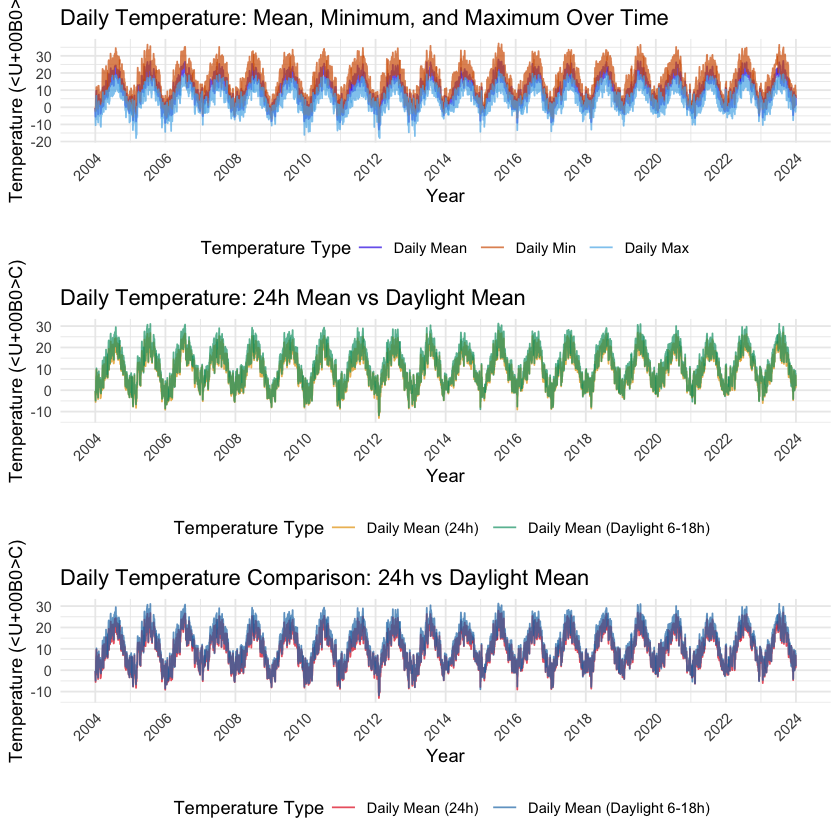

In [17]:
# Load ggplot2 for plotting
library(ggplot2)
library(tidyr)

# Add year column for plotting
temp_daily$year <- year(temp_daily$date)

# Reshape data to long format for plotting daily mean, min, and max
temp_long <- temp_daily %>%
    select(date, year, temp, tmin, tmax) %>%
    pivot_longer(cols = c(temp, tmin, tmax), 
                 names_to = "temp_type", 
                 values_to = "temp_value")

# Create first plot with contrasting colors using a palette
plot1 <- ggplot(temp_long, aes(x = date, y = temp_value, color = temp_type)) +
    geom_line(alpha = 0.7, size = 0.5) +
    scale_color_manual(values = c("temp" = "#3200e6", 
                                "tmin" = "#56B4E9", 
                                "tmax" = "#D55E00"),
                      labels = c("Daily Mean", "Daily Min", "Daily Max")) +
    scale_x_date(date_labels = "%Y", date_breaks = "2 years") +
    labs(title = "Daily Temperature: Mean, Minimum, and Maximum Over Time",
         x = "Year",
         y = "Temperature (°C)",
         color = "Temperature Type") +
    theme_minimal() +
    theme(axis.text.x = element_text(angle = 45, hjust = 1),
          legend.position = "bottom")

# Create second plot for Daily Mean and Day Temperature comparison
temp_comparison <- temp_daily %>%
    select(date, temp, temp_day) %>%
    pivot_longer(cols = c(temp, temp_day), 
                 names_to = "temp_type", 
                 values_to = "temp_value")

plot2 <- ggplot(temp_comparison, aes(x = date, y = temp_value, color = temp_type)) +
    geom_line(alpha = 0.7, size = 0.5) +
    scale_color_manual(values = c("temp" = "#E69F00", 
                                "temp_day" = "#009E73"),
                      labels = c("Daily Mean (24h)", "Daily Mean (Daylight 6-18h)")) +
    scale_x_date(date_labels = "%Y", date_breaks = "2 years") +
    labs(title = "Daily Temperature: 24h Mean vs Daylight Mean",
         x = "Year",
         y = "Temperature (°C)",
         color = "Temperature Type") +
    theme_minimal() +
    theme(axis.text.x = element_text(angle = 45, hjust = 1),
          legend.position = "bottom")

# Create third plot for Daily Mean and Day Temperature comparison only
plot3 <- ggplot(temp_comparison, aes(x = date, y = temp_value, color = temp_type)) +
    geom_line(alpha = 0.7, size = 0.5) +
    scale_color_manual(values = c("temp" = "#E31A1C", 
                                "temp_day" = "#1F78B4"),
                      labels = c("Daily Mean (24h)", "Daily Mean (Daylight 6-18h)")) +
    scale_x_date(date_labels = "%Y", date_breaks = "2 years") +
    labs(title = "Daily Temperature Comparison: 24h vs Daylight Mean",
         x = "Year",
         y = "Temperature (°C)",
         color = "Temperature Type") +
    theme_minimal() +
    theme(axis.text.x = element_text(angle = 45, hjust = 1),
          legend.position = "bottom")

# Combine plots using gridExtra
library(gridExtra)
combined_plot <- grid.arrange(plot1, plot2, plot3, nrow = 3)

# Create the directory for trend plots if it does not exist
if (!dir.exists("../data/01_data_prep/trend_plots")) {
    dir.create("../data/01_data_prep/trend_plots", recursive = TRUE)
}

# Save the combined plot as a PNG file
ggsave("../data/01_data_prep/trend_plots/01a_temperature_comparison_plot.png", plot = combined_plot, width = 18, height = 10, bg = "white", dpi = 300)
